# Figure - CoMIGHT varying n-samples prediction of metric

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import warnings

warnings.filterwarnings("ignore")

In [17]:
import math
import string
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.ticker import NullFormatter, ScalarFormatter, StrMethodFormatter
from sklearn.metrics import roc_auc_score

seed = 12345
rng = np.random.default_rng(seed)

In [18]:
root_dir = Path("/Users/spanda/Documents/output")

sim_names = ["mean_shiftv4", "multi_modalv2", "multi_equal"]

n_dims_1 = 512 - 6
n_samples = 1024
n_repeats = 100

# Plot Figure 5 (varying n_samples)

In [19]:
FIG_PATH = Path("/Users/spanda/Documents/output/figs")
FIG_PATH.mkdir(parents=True, exist_ok=True)

In [20]:
sim_names = ["mean_shiftv4", "multi_modalv2", "multi_equal"]

In [21]:
model_names = [
    "comight",
    "knn",
    # "knn_viewone",
    # "knn_viewtwo",
    # "might_viewone",
    # "might_viewtwo",
]

In [22]:
# varying n_samples
# df = pd.DataFrame()

# metric = "sas98"
# for model in model_names:
#     for sim_name in sim_names:
#         fname = (
#             root_dir
#             / f"results_vs_nsamples_{sim_name}_{model}_{metric}_{n_dims_1}_{n_repeats}.csv"
#         )
#         result_df = pd.read_csv(fname, index_col=None)

#         # display(result_df.head())

#         df = pd.concat((df, result_df), axis=0)

In [23]:
model_names = [
    "comight-cmi",
    "ksg",
]

In [24]:
# varying n_samples
# cmi_df = pd.DataFrame()

# metric = "cmi"
# for model in model_names:
#     for sim_name in sim_names:
#         fname = (
#             root_dir
#             / f"results_vs_nsamples_{sim_name}_{model}_{metric}_{n_dims_1}_{n_repeats}.csv"
#         )
#         result_df = pd.read_csv(fname, index_col=None)
#         cmi_df = pd.concat((cmi_df, result_df), axis=0)

In [25]:
df = pd.read_csv(root_dir / "results_vs_nsamples_sas98_506_100.csv", index_col=None)
cmi_df = pd.read_csv(root_dir / "results_vs_nsamples_cmi_506_100.csv", index_col=None)

In [26]:
print(df.shape)
display(df.head())

(1200, 5)


,n_samples,sim_type,model,metric,metric_value
0,128,mean_shiftv4,comight,sas98,0.015625
1,128,mean_shiftv4,comight,sas98,0.015625
2,128,mean_shiftv4,comight,sas98,0.046875
3,128,mean_shiftv4,comight,sas98,0.015625
4,128,mean_shiftv4,comight,sas98,0.000000


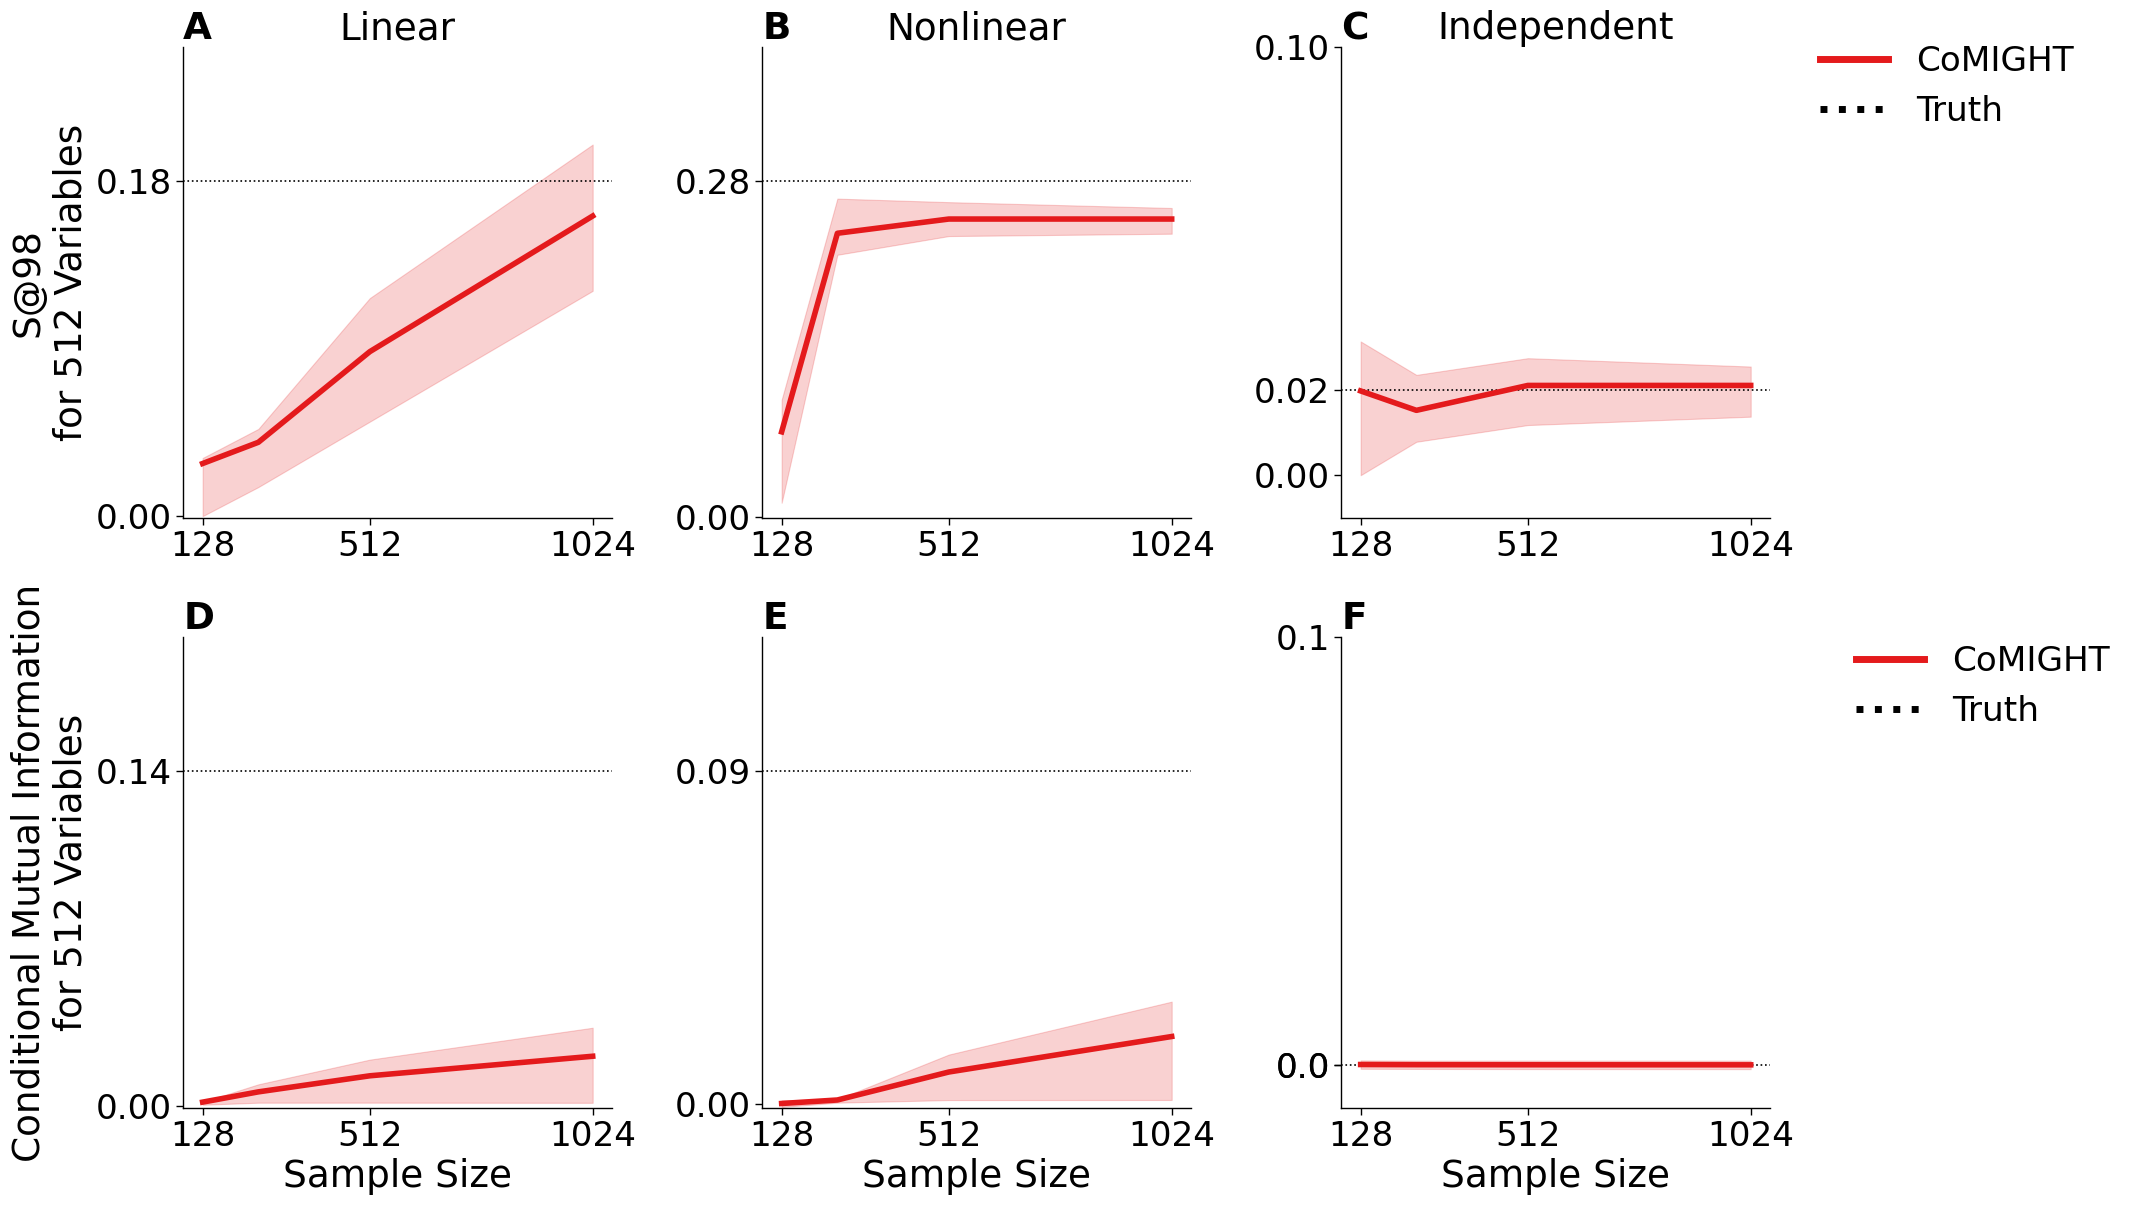

In [28]:
sns.set_context("paper", font_scale=2.8)

# in order of rows
truths = [
    {
        "mean_shiftv4": 0.18,
        "mean_shiftv3": 0.31,
        "multi_modalv2": 0.28,
        "multi_equal": 0.02,
    },
    {
        "mean_shiftv3": 0.11,
        "mean_shiftv4": 0.14,
        "multi_modalv2": 0.09,
        "multi_equal": 0.0,
    },
]

titles = ["Linear", "Nonlinear", "Independent"]

# plot the order of the dataframes per row
dfs = [
    df,
    cmi_df,
]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for irow in range(2):
    row_df = dfs[irow]

    for idx, sim_name in enumerate(sim_names):
        plot_df = row_df[row_df["sim_type"] == sim_name]

        plot_df["model"] = plot_df["model"].apply(lambda x: str(x).lower())
        plot_df["model"] = plot_df["model"].str.replace(
            "comight-cmi", "CoMIGHT", regex=False
        )
        plot_df["model"] = plot_df["model"].str.replace(
            "comight", "CoMIGHT", regex=False
        )
        plot_df["model"] = plot_df["model"].str.replace("knn", "KNN", regex=False)
        plot_df["model"] = plot_df["model"].str.replace("ksg", "KSG", regex=False)

        palette = {"CoMIGHT": "#e41a1c", "KNN": "#377eb8", "KSG": "#4daf4a"}

        # begin plotting
        ax = axs[irow][idx]

        ax.axhline([truths[irow][sim_name]], ls=":", label="Truth", color="#000000")

        hue_order = sorted([model for model in plot_df["model"].unique()])[::-1]
        ax = sns.lineplot(
            data=plot_df,
            x="n_samples",
            y="metric_value",
            hue="model",
            hue_order=hue_order,
            ax=ax,
            palette=palette,
            linewidth=4,
            errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
        )

        ax.set_xticks([128, 512, 1024])

        # set y lim and ticks
        ax.set_ylim([-0.001, truths[irow][sim_name] + 0.4 * truths[irow][sim_name]])
        if sim_name == "multi_equal":
            ax.set_yticks([0, 0.1, truths[irow][sim_name]])
        else:
            ax.set_yticks([0, truths[irow][sim_name]])

        if sim_name == "multi_equal":
            ax.set(ylim=[-0.01, 0.1])

        sns.despine(right=True, ax=ax)
        ax.get_legend().set_visible(False)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        if irow == 0:
            ax.set_title(titles[idx])

        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_title(
            string.ascii_uppercase[irow * len(sim_names) + idx],
            loc="left",
            weight="bold",
        )

    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for icol in range(len(sim_names)):
    axs[1][icol].set_xlabel("Sample Size")

axs[1][0].set_ylabel("Conditional Mutual Information\nfor 512 Variables")
axs[0][0].set_ylabel("S@98\nfor 512 Variables")
fig.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)
legend_locs = [(1.08, 0.99), (1.1, 0.49)]
for i in range(2):
    leg = axs[i][0].legend(
        bbox_to_anchor=legend_locs[i],
        bbox_transform=plt.gcf().transFigure,
        ncol=1,
        loc="upper center",
        reverse=True,
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

fig_name = "figure-5"
# plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches="tight")
plt.show()